# Problem 2. CLs plots

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zfit
from zfit import z
from scipy.stats import chi2
from tqdm.auto import tqdm
import multiprocess as mp

os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'

# data = np.load("../Data/toy_dataset.csv.npy")
data = np.load("../Data/toy_dataset_smaller_peak.npy")

/Users/jose/anaconda3/envs/envSpectreML/lib/python3.11/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/Users/jose/anaconda3/envs/envSpectreML/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Making a CLs plot. We will now make a typical CLs plot like that shown in Fig. 2. Remember that in CLs we talk about exclusion, so that your ”null” hypothesis that you would like to exclude is your signal and background hypothesis. IMPORTANT - again as we aren’t doing that many toys, for some of the points the test-statistic under the signal and background (i.e. null) hypothesis may not cover the data, in which case you may use Wilkes theoerm to extract a p-value. When I tested toys on both the large and small peak datasets, the test statistic under the background (i.e. alternative) hypothesis generally covered the data so this should be fine.

## a)

Use again the profile likelihood test statistic, but this time you have a test statistic for a given hypothesied particle mass, mSM . Generate the test-statistic in intervals of 5 MeV from mSM = 110 to mSM = 150 under the signal and background hypothesis. You should run 100-200 pseudodatasets per point. Provide all the test statistics on one plot.

---

### Solution



In [ ]:
obs = zfit.Space("x", limits=(np.min(data)-1, np.max(data)+1))
zfit_data = zfit.Data.from_numpy(obs=obs, array=data[:, 0])


def create_signal_model(mean_value, obs_space):
    mean = zfit.Parameter(f"mean_{mean_value}", mean_value, mean_value - 5, mean_value + 5)
    sigma = zfit.Parameter("sigma", 2.0, floating=False)  # Fixed detector resolution
    return zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs_space)

def create_signal_plus_background_model(mass, obs_space):
    signal_model = create_signal_model(mass, obs_space)
    lambda_sb = zfit.Parameter(f"lambda_sb_{mass}", -0.01, -1.0, 1.0)
    exp_bkg_model_sb = zfit.pdf.Exponential(lam=lambda_sb, obs=obs_space)
    frac_signal = zfit.Parameter(f"frac_signal_{mass}", 0.5, 0.0, 1.0)
    combined_model = zfit.pdf.SumPDF([exp_bkg_model_sb, signal_model], fracs=frac_signal)
    return combined_model

n_real = len(data)

mass_hypotheses = np.arange(110, 155, 5)  # 110 to 150 GeV in 5 GeV steps

n_pseudo = 200

def perform_pseudo_experiment(mass):
    global n_real, obs, exp_bkg_model, zfit
    sb_model = create_signal_plus_background_model(mass, obs)

    # Generate pseudo data: Signal+background model
    pseudo_data = sb_model.sample(n=n_real).numpy()
    zfit_pseudo_data = zfit.Data.from_numpy(obs=obs, array=pseudo_data[:, 0])

    # Fit the background-only model
    try:
        lambda_bkg = zfit.Parameter("lambda_bkg", -0.01, -1.0, 1.0)
        exp_bkg_model = zfit.pdf.Exponential(lam=lambda_bkg, obs=obs)
        nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_pseudo_data)
        minimizer_bkg = zfit.minimize.Minuit()
        res_bkg = minimizer_bkg.minimize(nll_bkg)
        nll_bkg_min = nll_bkg.value().numpy()
    except:
        return np.nan
    # Fit the signal+background model
    try:
        nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_pseudo_data)
        minimizer_sb = zfit.minimize.Minuit()
        res_sb = minimizer_sb.minimize(nll_sb)
        nll_sb_min = nll_sb.value().numpy()
    except:
        return np.nan

    t_stat = 2 * (nll_bkg_min - nll_sb_min)
    print(f"Mass: {mass}, T-statistic: {t_stat}")
    return t_stat


In [ ]:
pseudo_experiments = {
    mass: [perform_pseudo_experiment(mass) for _ in tqdm(range(n_pseudo))]
    for mass in mass_hypotheses
}

NameError: name 'mass_hypotheses' is not defined

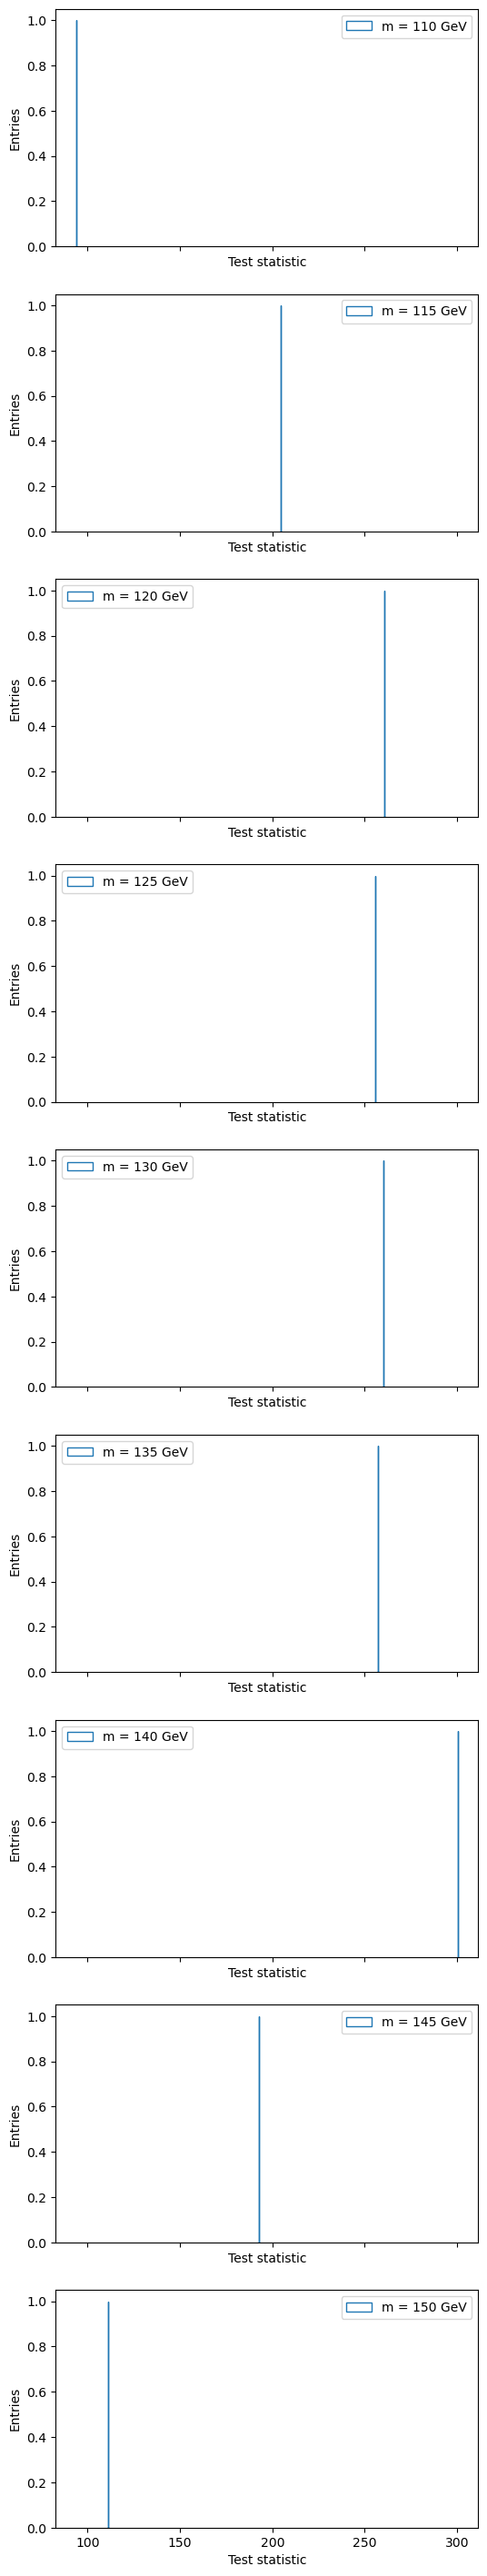

In [ ]:
fig, ax = plt.subplots(len(mass_hypotheses), 1, figsize=(6, 4 * len(mass_hypotheses),), sharex=True)
for i, mass in enumerate(mass_hypotheses):
    ax[i].hist(pseudo_experiments[mass], bins=50, histtype="step", label=f"m = {mass} GeV")
    ax[i].set_yscale("log")
    ax[i].set_xlabel(r"$-2 \Delta \log L$")
    ax[i].set_ylabel("Entries")
    ax[i].legend()

## b)

 Do the same again but for the background-only hypothesis. Will the test statistic generated under the background-only hypothesis change with different values of mSM ?

---
### Solution

Mass Hypotheses (H0): 100%|██████████| 9/9 [3:33:47<00:00, 1425.27s/it]  


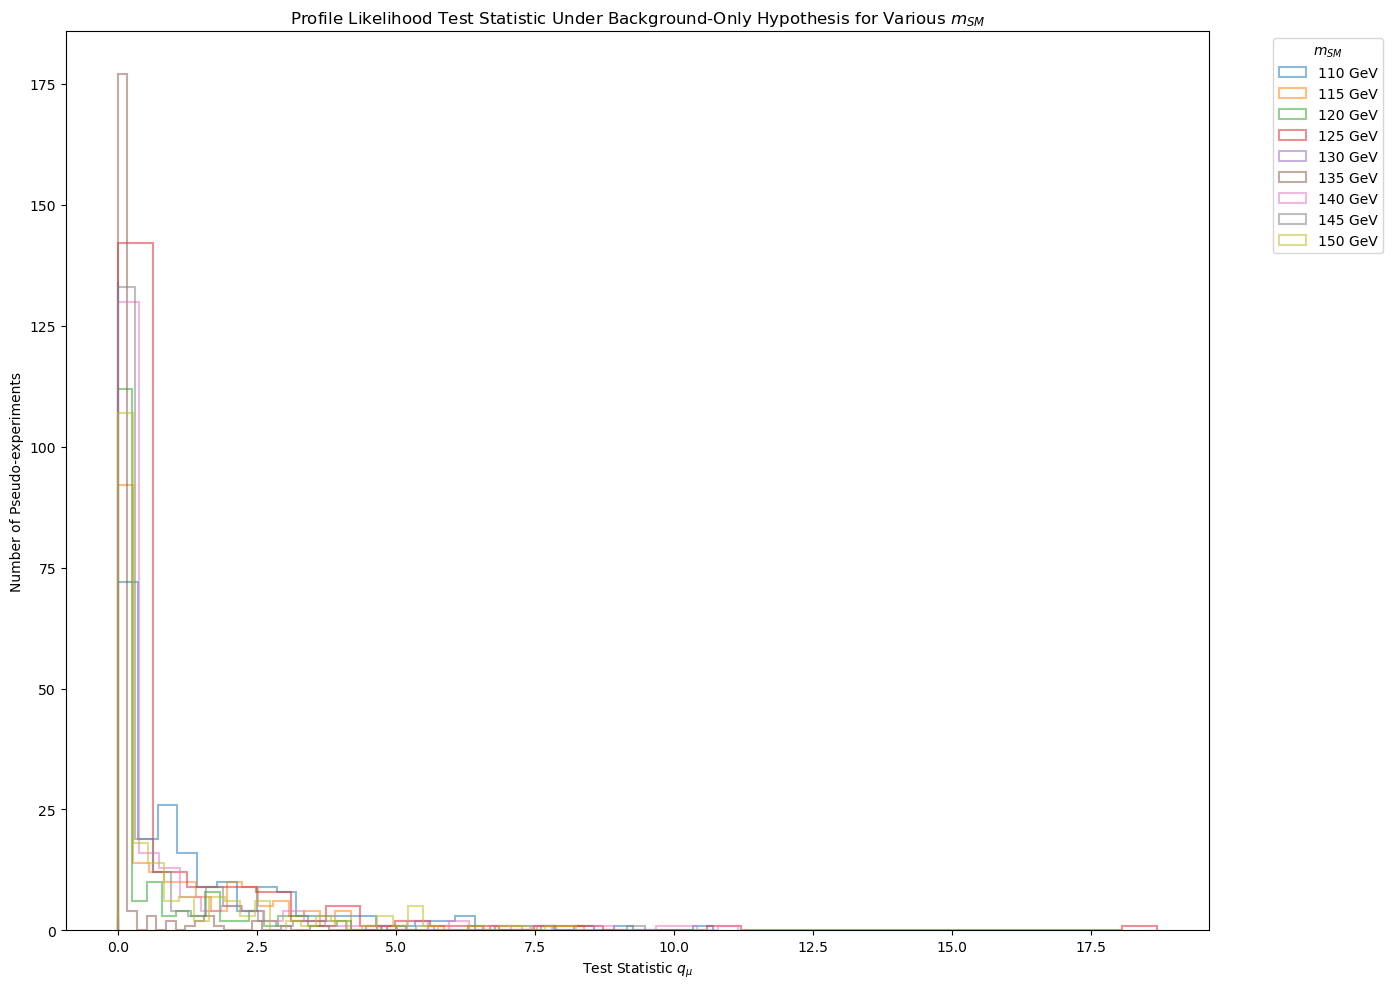

In [ ]:
def perform_pseudo_experiment_h0(mass):
    sb_model = create_signal_plus_background_model(mass, obs)

    pseudo_data = exp_bkg_model.sample(n=n_real).numpy()
    zfit_pseudo_data = zfit.Data.from_numpy(obs=obs, array=pseudo_data[:, 0])

    try:
        nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_pseudo_data)
        minimizer_bkg = zfit.minimize.Minuit()
        res_bkg = minimizer_bkg.minimize(nll_bkg)
        nll_bkg_min = nll_bkg.value().numpy()
    except:
        return np.nan

    try:
        nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_pseudo_data)
        minimizer_sb = zfit.minimize.Minuit()
        res_sb = minimizer_sb.minimize(nll_sb)
        nll_sb_min = nll_sb.value().numpy()
    except:
        return np.nan

    # Compute the test statistic
    q_mu = 2 * (nll_bkg_min - nll_sb_min)

    return q_mu

def run_pseudo_experiments_h0(mass, n_experiments):
    test_stats = []
    for _ in range(n_experiments):
        q_mu = perform_pseudo_experiment_h0(mass)
        if not np.isnan(q_mu):
            test_stats.append(q_mu)
    return test_stats

test_stats_dict_h0 = {}

for mass in tqdm(mass_hypotheses, desc="Mass Hypotheses (H0)"):
    test_stats = run_pseudo_experiments_h0(mass, n_pseudo)
    test_stats_dict_h0[mass] = test_stats

df_test_stats_h0 = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in test_stats_dict_h0.items()]))

plt.figure(figsize=(14, 10))
for mass in mass_hypotheses:
    plt.hist(df_test_stats_h0[mass].dropna(), bins=30, alpha=0.5, label=f"{mass} GeV", histtype='step', linewidth=1.5)

plt.xlabel('Test Statistic $q_\\mu$')
plt.ylabel('Number of Pseudo-experiments')
plt.title('Profile Likelihood Test Statistic Under Background-Only Hypothesis for Various $m_{SM}$')
plt.legend(title='$m_{SM}$', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## c)

Pick one of the mSM points, and calculate the power of the test-statistic for this point, assuming a confidence level of 0.05.

---

### Solution

In [ ]:
mSM_point = 125  # GeV

n_pseudo_power = 200

def perform_pseudo_experiment_h1(mass):
    sb_model = create_signal_plus_background_model(mass, obs)

    pseudo_data = sb_model.sample(n=n_real).numpy()
    zfit_pseudo_data = zfit.Data.from_numpy(obs=obs, array=pseudo_data[:, 0])

    try:
        nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_pseudo_data)
        minimizer_bkg = zfit.minimize.Minuit()
        res_bkg = minimizer_bkg.minimize(nll_bkg)
        nll_bkg_min = nll_bkg.value().numpy()
    except:
        return np.nan

    try:
        nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_pseudo_data)
        minimizer_sb = zfit.minimize.Minuit()
        res_sb = minimizer_sb.minimize(nll_sb)
        nll_sb_min = nll_sb.value().numpy()
    except:
        return np.nan

    q_mu = 2 * (nll_bkg_min - nll_sb_min)

    return q_mu

# Function to perform multiple pseudo-experiments under H1
def run_pseudo_experiments_h1(mass, n_experiments):
    test_stats = []
    for _ in range(n_experiments):
        q_mu = perform_pseudo_experiment_h1(mass)
        if not np.isnan(q_mu):
            test_stats.append(q_mu)
    return test_stats

# Perform pseudo-experiments under H1 for mSM = 125 GeV
print(f"Running {n_pseudo_power} pseudo-experiments under H1 for mSM = {mSM_point} GeV...")
test_stats_h1 = run_pseudo_experiments_h1(mSM_point, n_pseudo_power)

print(f"Number of successful pseudo-experiments: {len(test_stats_h1)} out of {n_pseudo_power}")

if 'test_stats_dict_h0' not in globals():
    print("Generating test statistics under H0 for mSM = 125 GeV...")

    def perform_pseudo_experiment_h0_specific(mass):
        sb_model = create_signal_plus_background_model(mass, obs)

        pseudo_data = exp_bkg_model.sample(n=n_real).numpy()
        zfit_pseudo_data = zfit.Data.from_numpy(obs=obs, array=pseudo_data[:, 0])

        try:
            nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_pseudo_data)
            minimizer_bkg = zfit.minimize.Minuit()
            res_bkg = minimizer_bkg.minimize(nll_bkg)
            nll_bkg_min = nll_bkg.value().numpy()
        except:
            return np.nan

        try:
            nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_pseudo_data)
            minimizer_sb = zfit.minimize.Minuit()
            res_sb = minimizer_sb.minimize(nll_sb)
            nll_sb_min = nll_sb.value().numpy()
        except:
            return np.nan

        q_mu = 2 * (nll_bkg_min - nll_sb_min)

        return q_mu

    def run_pseudo_experiments_h0_specific(mass, n_experiments):
        test_stats = []
        for _ in range(n_experiments):
            q_mu = perform_pseudo_experiment_h0_specific(mass)
            if not np.isnan(q_mu):
                test_stats.append(q_mu)
        return test_stats

    test_stats_h0_specific = run_pseudo_experiments_h0_specific(mSM_point, n_pseudo_power)
    print(f"Number of successful pseudo-experiments under H0: {len(test_stats_h0_specific)} out of {n_pseudo_power}")
else:
    test_stats_h0_specific = test_stats_dict_h0[mSM_point]

q_critical = np.percentile(test_stats_h0_specific, 95)
print(f"q_critical (95th percentile under H0): {q_critical}")

power = np.sum(np.array(test_stats_h1) > q_critical) / len(test_stats_h1)
print(f"Power of the test at mSM = {mSM_point} GeV: {power:.3f}")


Running 200 pseudo-experiments under H1 for mSM = 125 GeV...
Number of successful pseudo-experiments: 200 out of 200
q_critical (95th percentile under H0): 3.9109143742488186
Power of the test at mSM = 125 GeV: 1.000


## d)

Use this ensemble of test statistics to make the CLs plot, with one entry for each of the points of mSM you have calculated the test statistics for.

---

### Solution



In [ ]:

n_real = len(data)

mass_hypotheses = np.arange(110, 155, 5)  # 110 to 150 GeV in 5 GeV steps

n_pseudo_CLs = 200  # Adjust as needed (100-200 as per the problem statement)

test_stats_h0_dict = {}
test_stats_h1_dict = {}

def perform_pseudo_experiment_h0_full(mass):
    sb_model = create_signal_plus_background_model(mass, obs)

    pseudo_data = exp_bkg_model.sample(n=n_real).numpy()
    zfit_pseudo_data = zfit.Data.from_numpy(obs=obs, array=pseudo_data[:, 0])

    try:
        nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_pseudo_data)
        minimizer_bkg = zfit.minimize.Minuit()
        res_bkg = minimizer_bkg.minimize(nll_bkg)
        nll_bkg_min = nll_bkg.value().numpy()
    except:
        return np.nan

    try:
        nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_pseudo_data)
        minimizer_sb = zfit.minimize.Minuit()
        res_sb = minimizer_sb.minimize(nll_sb)
        nll_sb_min = nll_sb.value().numpy()
    except:
        return np.nan

    q_mu = 2 * (nll_bkg_min - nll_sb_min)

    return q_mu

def perform_pseudo_experiment_h1_full(mass):
    # Create the S+B model for this mass
    sb_model = create_signal_plus_background_model(mass, obs)

    # Sample pseudo-data from the S+B model
    pseudo_data = sb_model.sample(n=n_real).numpy()
    zfit_pseudo_data = zfit.Data.from_numpy(obs=obs, array=pseudo_data[:, 0])

    # Fit the background-only model to pseudo-data
    try:
        nll_bkg = zfit.loss.UnbinnedNLL(model=exp_bkg_model, data=zfit_pseudo_data)
        minimizer_bkg = zfit.minimize.Minuit()
        res_bkg = minimizer_bkg.minimize(nll_bkg)
        nll_bkg_min = nll_bkg.value().numpy()
    except:
        # If the fit fails, return NaN
        return np.nan

    # Fit the S+B model to pseudo-data
    try:
        nll_sb = zfit.loss.UnbinnedNLL(model=sb_model, data=zfit_pseudo_data)
        minimizer_sb = zfit.minimize.Minuit()
        res_sb = minimizer_sb.minimize(nll_sb)
        nll_sb_min = nll_sb.value().numpy()
    except:
        # If the fit fails, return NaN
        return np.nan

    # Compute the test statistic
    q_mu = 2 * (nll_bkg_min - nll_sb_min)

    return q_mu

# Function to perform multiple pseudo-experiments for a given mass under H0
def run_pseudo_experiments_h0(mass, n_experiments):
    test_stats = []
    for _ in range(n_experiments):
        q_mu = perform_pseudo_experiment_h0_full(mass)
        if not np.isnan(q_mu):
            test_stats.append(q_mu)
    return test_stats

# Function to perform multiple pseudo-experiments for a given mass under H1
def run_pseudo_experiments_h1(mass, n_experiments):
    test_stats = []
    for _ in range(n_experiments):
        q_mu = perform_pseudo_experiment_h1_full(mass)
        if not np.isnan(q_mu):
            test_stats.append(q_mu)
    return test_stats

# Perform pseudo-experiments for all mass hypotheses under H0 and H1
for mass in tqdm(mass_hypotheses, desc="Mass Hypotheses"):
    # Under H0 (background-only)
    test_stats_h0 = run_pseudo_experiments_h0(mass, n_pseudo_CLs)
    test_stats_h0_dict[mass] = test_stats_h0

    # Under H1 (signal+background)
    test_stats_h1 = run_pseudo_experiments_h1(mass, n_pseudo_CLs)
    test_stats_h1_dict[mass] = test_stats_h1

# Convert dictionaries to DataFrames for easier handling
df_test_stats_h0 = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in test_stats_h0_dict.items()]))
df_test_stats_h1 = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in test_stats_h1_dict.items()]))

# Now, for each mSM, calculate CLs
CLs_values = []
for mass in mass_hypotheses:
    q_mu_h0 = df_test_stats_h0[mass].dropna().values
    q_mu_h1 = df_test_stats_h1[mass].dropna().values

    q_critical = np.percentile(q_mu_h0, 95)

    CL_SplusB = np.sum(q_mu_h1 > q_critical) / len(q_mu_h1)

    CL_B = 0.05  # Since q_critical is the 95th percentile, CL_B = 1 - 0.95 = 0.05

    CLs = CL_SplusB / CL_B
    CLs_values.append(CLs)

CLs_values = np.array(CLs_values)

plt.figure(figsize=(10, 6))
plt.plot(mass_hypotheses, CLs_values, marker='o', linestyle='-', color='blue', label='CLs')
plt.axhline(0.05, color='red', linestyle='--', label='CLs = 0.05 (95% CL)')
plt.xlabel('$m_{SM}$ (GeV)')
plt.ylabel('$CL_s$')
plt.title('CLs Exclusion Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Mass Hypotheses:  22%|██▏       | 2/9 [15:26:43<60:10:33, 30947.62s/it]

(e) Comment on the plot - where can you exclude the signal and background hypothesis with 95% CL, where can’t you? Is this plot as your expect. How would you improve this plot?